In [87]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
def diff_sar_step(vip, vin, vref, k):
    d = None
    
    if vip > vin:
        d = 1
        vip = vip - vref / (2 ** k)
    else:
        d = 0
        vin = vin - vref / (2 ** k)

    return d, vip, vin

def diff_sar_step_monotonic(vip, vin, vref, k):
    if k > 4:
        return diff_sar_step(vip, vin, vref, k)

    d = None
    
    if vip >= vin:
        d = 1
        vip = vip - vref / (2 ** (k + 1))
        vin = vin + vref / (2 ** (k + 1))
    else:
        d = 0
        vin = vin - vref / (2 ** (k + 1))
        vip = vip + vref / (2 ** (k + 1))

    return d, vip, vin

def result_convert(ds):
    result = 0
    for i in range(len(ds)):
        result += ds[i] * (2 ** (len(ds) - i - 1))
    return result

In [89]:
k = 1
n = 8
vref = 1.5
vip = 1.25
vin = 0.25

vips =[vip, vip]
vins =[vin, vin]
ds = []

while k < n:
    d, vip, vin = diff_sar_step(vip, vin, vref, k)
    vips.append(vip)
    vins.append(vin)
    ds.append(d)
    k += 1

d, _, _ = diff_sar_step(vip, vin, vref, k)
ds.append(d)
print(f"SAR result: 0x{result_convert(ds):X}")

SAR result: 0xD5


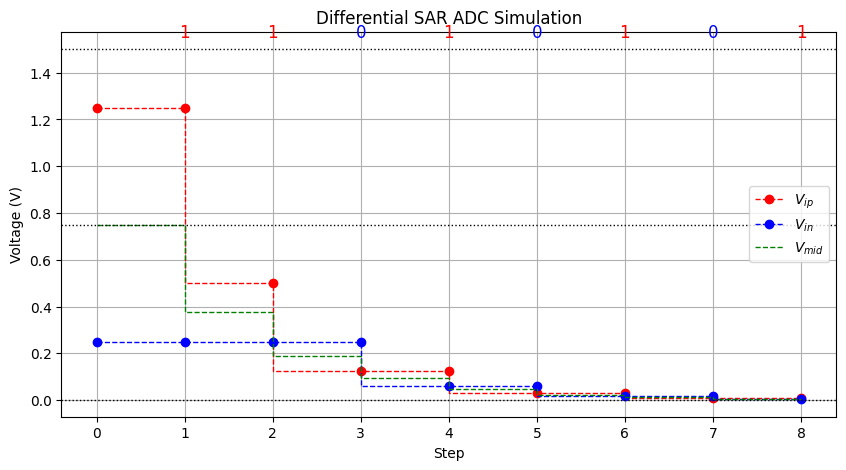

In [90]:
plt.figure(figsize=(10, 5))

# Plot the results
plt.plot(range(len(vips)), vips, label='$V_{{ip}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='red')
plt.plot(range(len(vins)), vins, label='$V_{{in}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='blue')
plt.plot(range(len(vins)), [(vip + vin) / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')

# Add reference voltage lines
plt.axhline(y=vref, color='black', linestyle=':', linewidth=1)
plt.axhline(y=vref/2, color='black', linestyle=':', linewidth=1)
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

# Add step markers for decisions
for i, d in enumerate(ds):
    if d == 1:
        plt.text(i + 1, vref + 0.05, '1', fontsize=12, ha='center', color='red')
    else:
        plt.text(i + 1, vref + 0.05, '0', fontsize=12, ha='center', color='blue')


plt.title('Differential SAR ADC Simulation')
plt.xlabel('Step')
plt.ylabel('Voltage (V)')
plt.xticks(range(len(vips)))
plt.grid()
plt.legend()
plt.show()

In [91]:
k = 1
n = 8
vref = 1.5
vip = 0.6
vin = 0.9

vips =[vip, vip]
vins =[vin, vin]
ds = []

while k < n:
    d, vip, vin = diff_sar_step_monotonic(vip, vin, vref, k)
    vips.append(vip)
    vins.append(vin)
    ds.append(d)
    k += 1

d, _, _ = diff_sar_step_monotonic(vip, vin, vref, k)
ds.append(d)
print(f"SAR result: 0x{result_convert(ds):X}")

SAR result: 0x66


In [92]:
def convert(vip, vin, vref=1.5, n=8):
    k = 1
    vips = [vip, vip]
    vins = [vin, vin]
    ds = []

    while k < n:
        d, vip, vin = diff_sar_step(vip, vin, vref, k)
        vips.append(vip)
        vins.append(vin)
        ds.append(d)
        k += 1

    d, _, _ = diff_sar_step(vip, vin, vref, k)
    ds.append(d)
    
    return result_convert(ds)

In [93]:
vdiffs = np.linspace(-1.3, 1.3, 14)
print(vdiffs)
vips = (vdiffs + 1.5) / 2
vins = (1.5 - vdiffs) / 2

print()

expecteds = np.array([convert(vip, vin) for vip, vin in zip(vips, vins)]).astype(np.uint8)
expecteds_theo = np.linspace(0, 255, 16).astype(np.uint8)

for exp, exp_theo in zip(expecteds, expecteds_theo):
    print(f"{exp:08b} (0x{exp:02X})   (0x{exp_theo:02X}) {exp_theo:08b}")

[-1.3 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9  1.1  1.3]

00010001 (0x11)   (0x00) 00000000
00100010 (0x22)   (0x11) 00010001
00110011 (0x33)   (0x22) 00100010
01000100 (0x44)   (0x33) 00110011
01010101 (0x55)   (0x44) 01000100
01100110 (0x66)   (0x55) 01010101
01110111 (0x77)   (0x66) 01100110
10001000 (0x88)   (0x77) 01110111
10011001 (0x99)   (0x88) 10001000
10101010 (0xAA)   (0x99) 10011001
10111011 (0xBB)   (0xAA) 10101010
11001100 (0xCC)   (0xBB) 10111011
11011101 (0xDD)   (0xCC) 11001100
11101110 (0xEE)   (0xDD) 11011101


In [94]:
vips = np.array(vips)
vins = np.array(vins)
vdiffs = vips - vins
expecteds = np.array(expecteds)

test_initial_time = 9
test_interval_time = 8


def generate_pwl(t_init: int, t_interval: int, voltages: np.ndarray) -> str:
    times = np.arange(t_init, t_init + len(voltages) * t_interval, t_interval)
    times = np.repeat(times, 2)
    times = np.insert(times, 0, 0)
    times = times[:-1]
    print(f"t_max: {times[-1]}")

    voltages = np.repeat(voltages, 2)

    result = "pwl("
    for t, v in zip(times, voltages):
        if t != 0:
            result += f"{{{t:d}/f}} {v:.2f} "
        else:
            result += f"0 {v:.2f} "

    return result.strip() + ")"

pwl_pos = generate_pwl(test_initial_time, test_interval_time, vips)
pwl_neg = generate_pwl(test_initial_time, test_interval_time, vins)

print(f"pwl_pos:\n\t{pwl_pos}")
print(f"pwl_neg:\n\t{pwl_neg}")

t_max: 113
t_max: 113
pwl_pos:
	pwl(0 0.10 {9/f} 0.10 {9/f} 0.20 {17/f} 0.20 {17/f} 0.30 {25/f} 0.30 {25/f} 0.40 {33/f} 0.40 {33/f} 0.50 {41/f} 0.50 {41/f} 0.60 {49/f} 0.60 {49/f} 0.70 {57/f} 0.70 {57/f} 0.80 {65/f} 0.80 {65/f} 0.90 {73/f} 0.90 {73/f} 1.00 {81/f} 1.00 {81/f} 1.10 {89/f} 1.10 {89/f} 1.20 {97/f} 1.20 {97/f} 1.30 {105/f} 1.30 {105/f} 1.40 {113/f} 1.40)
pwl_neg:
	pwl(0 1.40 {9/f} 1.40 {9/f} 1.30 {17/f} 1.30 {17/f} 1.20 {25/f} 1.20 {25/f} 1.10 {33/f} 1.10 {33/f} 1.00 {41/f} 1.00 {41/f} 0.90 {49/f} 0.90 {49/f} 0.80 {57/f} 0.80 {57/f} 0.70 {65/f} 0.70 {65/f} 0.60 {73/f} 0.60 {73/f} 0.50 {81/f} 0.50 {81/f} 0.40 {89/f} 0.40 {89/f} 0.30 {97/f} 0.30 {97/f} 0.20 {105/f} 0.20 {105/f} 0.10 {113/f} 0.10)


In [100]:
# measurements = [
#     0x00, 0x0F, 0x20, 0x31, 0x43, 0x54, 0x66, 0x77, 0x88, 0x99, 0xAB, 0xBC, 0xCE, 0xDF, 0xF0, 0xFF
# ]
old = [
    0x0F, 0x20, 0x32, 0x43, 0x54, 0x66, 0x77, 0x88, 0x99, 0xAB, 0xBC, 0xCD, 0xDF, 0xF0
]

new = [
    0x10, 0x21, 0x32, 0x43, 0x54, 0x66, 0x77, 0x88, 0x99, 0xAB, 0xBC, 0xCD, 0xDE, 0xEF
]

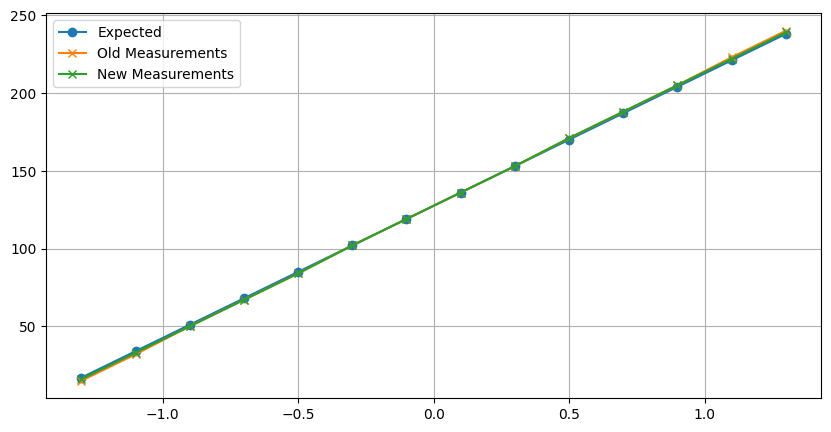

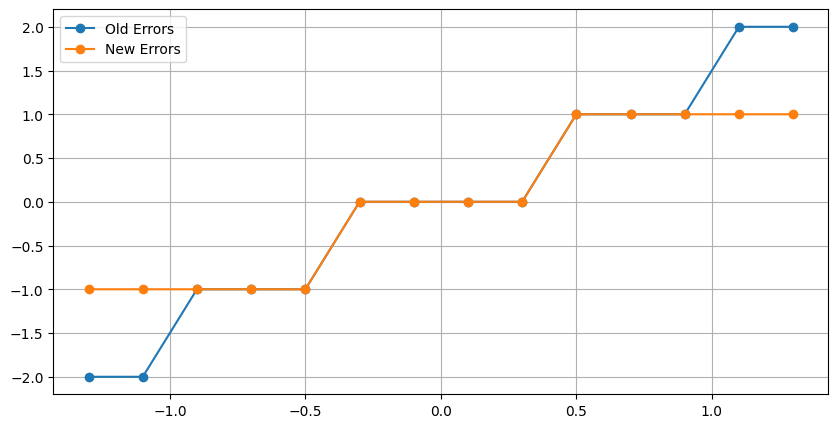

In [101]:
old = np.array(old)
new = np.array(new)

plt.figure(figsize=(10, 5))
plt.plot(vdiffs, expecteds, "o-", label="Expected")
plt.plot(vdiffs, old, "x-", label="Old Measurements")
plt.plot(vdiffs, new, "x-", label="New Measurements")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vdiffs, old - expecteds, "o-", label="Old Errors")
plt.plot(vdiffs, new - expecteds, "o-", label="New Errors")
plt.legend()
plt.grid()
plt.show()

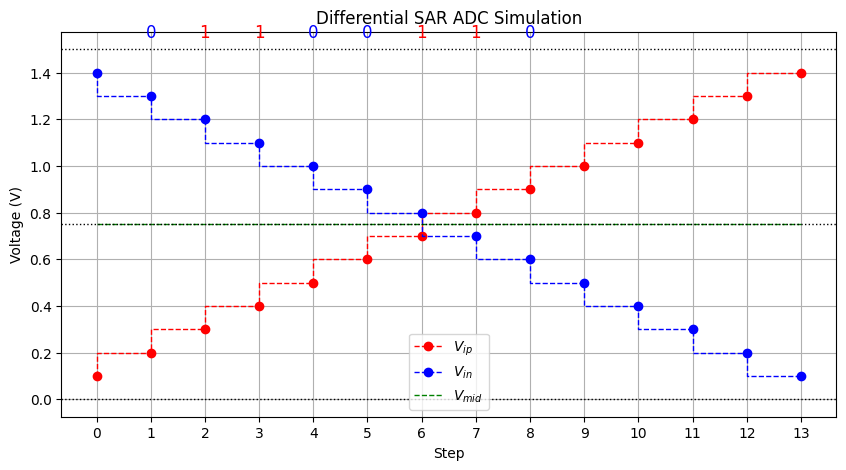

In [102]:
plt.figure(figsize=(10, 5))

# Plot the results
plt.plot(range(len(vips)), vips, label='$V_{{ip}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='red')
plt.plot(range(len(vins)), vins, label='$V_{{in}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='blue')
plt.plot(range(len(vins)), [(vip + vin) / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')

# Add reference voltage lines
plt.axhline(y=vref, color='black', linestyle=':', linewidth=1)
plt.axhline(y=vref/2, color='black', linestyle=':', linewidth=1)
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

# Add step markers for decisions
for i, d in enumerate(ds):
    if d == 1:
        plt.text(i + 1, vref + 0.05, '1', fontsize=12, ha='center', color='red')
    else:
        plt.text(i + 1, vref + 0.05, '0', fontsize=12, ha='center', color='blue')


plt.title('Differential SAR ADC Simulation')
plt.xlabel('Step')
plt.ylabel('Voltage (V)')
plt.xticks(range(len(vips)))
plt.grid()
plt.legend()
plt.show()

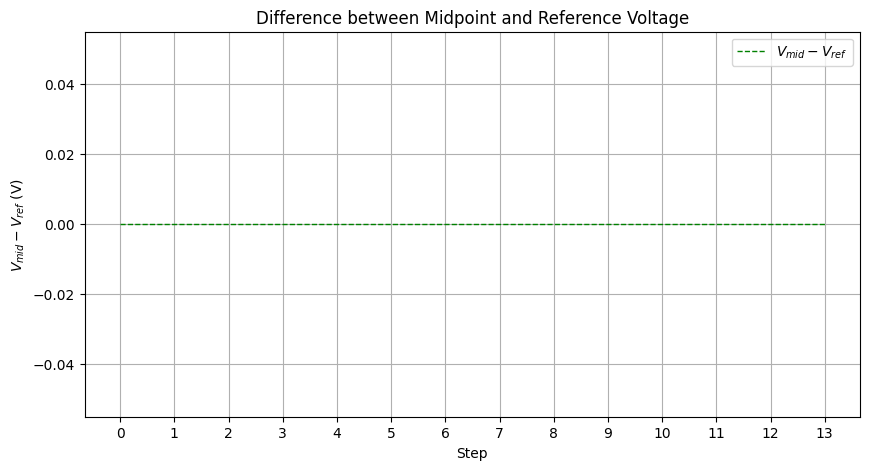

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(vins)), [(vip + vin) / 2 - vref / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}} - V_{{ref}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')
plt.title('Difference between Midpoint and Reference Voltage')
plt.xlabel('Step')
plt.ylabel('$V_{{mid}} - V_{{ref}}$ (V)')
plt.xticks(range(len(vins)))
plt.grid()
plt.legend()
plt.show()